# Zee: Zero Effort Crowdsourcing for Indoor Localization

This notebook implements the algorithm described in the Zee paper.

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import json

from pathlib import Path
from datetime import datetime

In [35]:
import shapely

In [2]:
import sklearn

In [3]:
import scipy

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
INDOOR_COMPETITION_20_DIR = os.path.join(PROJECT_HOME, "code", "indoor-location-competition-20")
print("The library is located at", INDOOR_COMPETITION_20_DIR)
sys.path.append(INDOOR_COMPETITION_20_DIR)

The library is located at ./../../code/indoor-location-competition-20


In [6]:
# type: ignore
from compute_f import split_ts_seq, compute_step_positions
from io_f import read_data_file
from visualize_f import visualize_trajectory, visualize_heatmap, save_figure_to_html

In [7]:
floor_data_dir = os.path.join(INDOOR_COMPETITION_20_DIR, "data", "site1", "F2")
path_data_dir = os.path.join(floor_data_dir, "path_data_files")
floor_plan_filename = os.path.join(floor_data_dir, "floor_image.png")
floor_info_filename = os.path.join(floor_data_dir, "floor_info.json")
floor_map_filename  = os.path.join(floor_data_dir, "geojson_map.json")

## Data Extraction

In [8]:
path_filenames = list(Path(path_data_dir).resolve().glob("*.txt"))

In [9]:
path_filename = path_filenames[0]
path_datas = read_data_file(path_filename)

In [10]:
acce_datas = path_datas.acce
magn_datas = path_datas.magn
ahrs_datas = path_datas.ahrs
wifi_datas = path_datas.wifi
ibeacon_datas = path_datas.ibeacon
posi_datas = path_datas.waypoint

In [11]:
gt_times = path_datas.waypoint[:, 0]
gt_location = path_datas.waypoint[:, 1:]

## Counting Steps

In [12]:
ts = path_datas.acce[:, 0].astype(np.int64)

acce_x = path_datas.acce[:, 1]
acce_x = (acce_x - np.mean(acce_x)) / np.std(acce_x)

acce_y = path_datas.acce[:, 2]
acce_y = (acce_y - np.mean(acce_y)) / np.std(acce_y)

acce_z = path_datas.acce[:, 3]
acce_z = (acce_z - np.mean(acce_z)) / np.std(acce_z)

acce = path_datas.acce[:, 1:]
acce = (acce - np.mean(acce, axis=0)) / np.std(acce, axis=0)

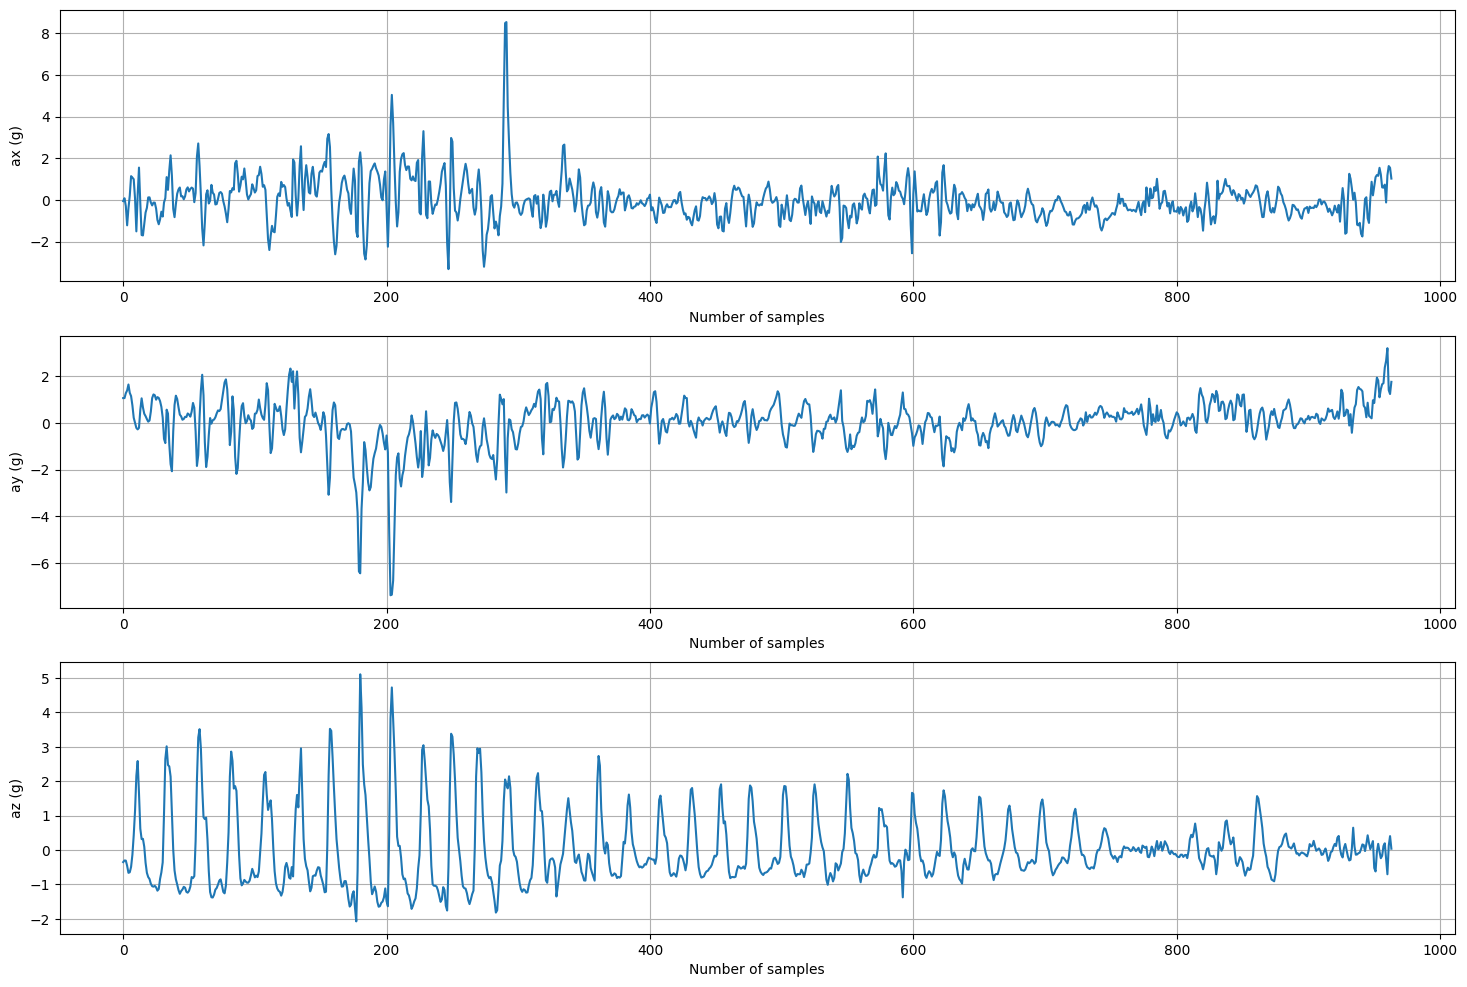

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(18, 12),)

ax1.plot(acce_x)
ax1.set_ylabel("ax (g)")
ax1.set_xlabel("Number of samples")

ax2.plot(acce_y)
ax2.set_ylabel("ay (g)")
ax2.set_xlabel("Number of samples")

ax3.plot(acce_z)
ax3.set_ylabel("az (g)")
ax3.set_xlabel("Number of samples")

ax1.grid()
ax2.grid()
ax3.grid()

### Normalized Auto-correlation based Step Counting (NASC)

* The intuition behind NASC is that if the user is walking, then the auto-correlation will spike at the correct periodicity of the walker.

In [14]:
def norm_acf(a, m, t):
  mu_m, sigma_m = np.mean(a[m:m+t], axis=0), np.std(a[m:m+t], axis=0)
  mu_mt, sigma_mt = np.mean(a[m+t:m+t*2], axis=0), np.std(a[m+t:m+t*2], axis=0)

  n_acf = np.sum((a[m:m+t] - mu_m) * (a[m+t:m+t*2] - mu_mt), axis=0) / t / sigma_m / sigma_mt

  return np.mean(n_acf)

In [15]:
accelerometer_sampling_freq = ts.shape[0] / (ts[-1] / 1000 - ts[0] / 1000)
print(
    "The sampling frequency of accelerometer is {:.2f}Hz".format(accelerometer_sampling_freq)
)

The sampling frequency of accelerometer is 49.71Hz


In [16]:
def max_norm_acf(a, m, t_min=40, t_max=100):
  """
  Finding the maximum normalized auto-correlation.
  """
  t_best = t_min
  n_acf_best = norm_acf(a, m, t_best)
  for t in range(t_min, t_max + 1):
    n_acf = norm_acf(a, m, t)
    if n_acf > n_acf_best:
      t_best = t
      n_acf_best = n_acf
  return n_acf_best, t_best


In [17]:
STATE_IDLE = "IDLE"
STATE_WALKING = "WALKING"

def get_state(acce, m, prev_state=None, prev_t_opt=None):
  if prev_t_opt is not None:
    t_min, t_max = max(40, prev_t_opt - 10), min(100, prev_t_opt + 10)
  else:
    t_min, t_max = 40, 100
  
  n_acf, t_opt = max_norm_acf(acce, m=m, t_min=t_min, t_max=t_max)
  
  sigma = np.mean(np.std(acce[m:m+t_opt], axis=0))
  if sigma < 0.01:
    return STATE_IDLE, t_opt
  
  if n_acf > 0.7:
    return STATE_WALKING, t_opt
  
  return prev_state, t_opt


In [18]:
get_state(acce, m=50)

('WALKING', 49)

## Estimating Heading Offset Range

### Spectrum of Walking

In [19]:
def show_spectrum(signal_data, fs):
  n_samples = len(signal_data)
  duration = n_samples / fs
  t = np.linspace(0, duration, int(fs * duration), endpoint=False)

  frequencies, spectrum = scipy.signal.periodogram(signal_data, fs=fs)

  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

  ax1.plot(t, signal_data)
  ax1.set_xlabel("Time (s)")
  ax1.set_ylabel("Amplitude")
  ax1.set_title("Time Domain Signal")

  ax2.plot(frequencies, spectrum)
  ax2.set_xlabel("Frequency (Hz)")
  ax2.set_ylabel("Magnitude")
  ax2.set_title("Frequency Spectrum")

  plt.tight_layout()
  plt.show()

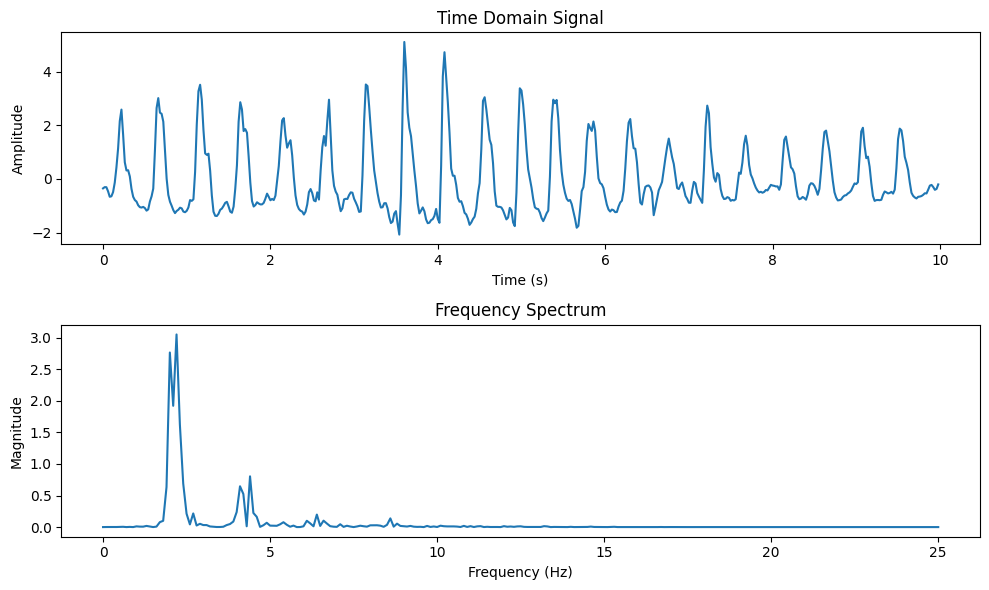

In [20]:
show_spectrum(acce_z[:500], fs=50)

In [21]:
def find_fundamental_frequency(frequencies, spectrum):
  idx = np.argmax(spectrum)
  return frequencies[idx], spectrum[idx]

In [22]:
def find_fundamental_frequency_and_harmonics(frequencies, spectrum, harmonics=[2,3,4]):
  fundamental_frequency, amplitude = find_fundamental_frequency(frequencies, spectrum)
  harmonics_found = [harmonic for harmonic in harmonics if harmonic * fundamental_frequency in frequencies]
  return fundamental_frequency, amplitude, harmonics_found

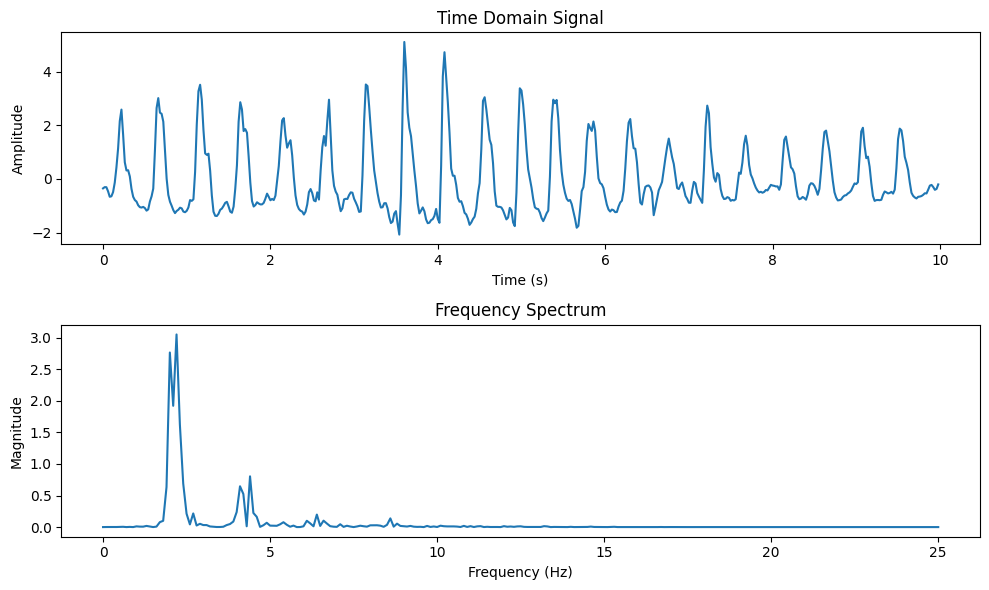

Fundamental Frequency: 2.2 Hz, Magnitude: 3.05
Harmonics Found: [2, 3, 4]


In [24]:
show_spectrum(acce_z[:500], fs=50)

# Find the fundamental frequency and its harmonics
frequencies, spectrum = scipy.signal.periodogram(acce_z[:500], fs=50)
harmonics = [2, 3, 4]
fundamental_frequency, amplitude, harmonics_found = find_fundamental_frequency_and_harmonics(frequencies, spectrum, harmonics)

print(f"Fundamental Frequency: {fundamental_frequency} Hz, Magnitude: {amplitude:.2f}")
print(f"Harmonics Found: {harmonics_found}")

## Augmented Particle Filter

### Reading Map Data

In [ ]:
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon

In [56]:
from shapely import ops as shapely_ops

In [93]:
import pyproj

In [ ]:
with open(floor_info_filename) as f:
  floor_info = json.load(f)

In [ ]:
with open(floor_map_filename) as f:
  floor_map = json.load(f)

In [91]:
np.sqrt(239.81749314504376**2 + 176.66380763697**2)

297.86327559329203

In [27]:
floor_info

{'map_info': {'height': 176.66380763697, 'width': 239.81749314504376}}

In [41]:
pd.DataFrame(floor_map["features"])

,type,geometry,properties,order,crs,id
0,Feature,"{'type': 'MultiPolygon', 'coordinates': [[[[12...","{'Vr': '000200', 'category': 'floor', 'name': ...",1.0,"{'type': 'link', 'properties': {'href': 'http:...",5dd3d7732a57a34356595940
1,Feature,"{'coordinates': [[[120.07617899999798, 30.2935...","{'id': '5dd3d7742a57a34356595a78', 'version': ...",NaN,NaN,5dd3d7742a57a34356595a78
2,Feature,"{'coordinates': [[[120.07588699999798, 30.2936...","{'id': '5dd3d7742a57a34356595a64', 'version': ...",NaN,NaN,5dd3d7742a57a34356595a64
3,Feature,"{'coordinates': [[[120.07603499999797, 30.2930...","{'id': '5dd3d7742a57a34356595a5b', 'version': ...",NaN,NaN,5dd3d7742a57a34356595a5b
4,Feature,"{'coordinates': [[[120.07605299999797, 30.2929...","{'id': '5dd3d7742a57a34356595a71', 'version': ...",NaN,NaN,5dd3d7742a57a34356595a71
...,...,...,...,...,...,...
134,Feature,"{'type': 'Polygon', 'coordinates': [[[120.0758...","{'id': '5dd3d7742a57a34356595abf', 'version': ...",NaN,NaN,5dd3d7742a57a34356595abf
135,Feature,"{'type': 'Polygon', 'coordinates': [[[120.0759...","{'id': '5dd3d7742a57a34356595ab7', 'version': ...",NaN,NaN,5dd3d7742a57a34356595ab7
136,Feature,"{'type': 'Polygon', 'coordinates': [[[120.0755...","{'id': '5dd3d7742a57a34356595a7c', 'version': ...",NaN,NaN,5dd3d7742a57a34356595a7c
137,Feature,"{'type': 'Polygon', 'coordinates': [[[120.0760...","{'id': '5dd3d7742a57a34356595a63', 'version': ...",NaN,NaN,5dd3d7742a57a34356595a63


In [88]:
floor_map["features"][0]["crs"]

{'type': 'link',
 'properties': {'href': 'http://spatialreference.org/ref/sr-org/6928/ogcwkt/',
  'type': 'ogcwkt'}}

In [122]:
floor_multipolygon = shape(floor_map["features"][0]["geometry"])

In [60]:
# Polygons representing stores

store_polygons = [shape(feature["geometry"]) for feature in floor_map["features"][1:]]

union_store_polygon = shapely_ops.unary_union(store_polygons)

In [67]:
len(floor_multipolygon.geoms)

2

In [68]:
floor_polygon = floor_multipolygon.geoms[0]

In [78]:
def plot_polygon(polygon, ax, **kwargs):
  x, y = polygon.exterior.xy
  ax.plot(x, y, **kwargs)

In [121]:
# Get the bound of the polygon

x_all, y_all = [], []

x_min, y_min = float("inf"), float("inf")
x_max, y_max = float("-inf"), float("-inf")

for floor_polygon in floor_multipolygon.geoms:
  x, y = floor_polygon.exterior.xy
  x_min = min(x_min, min(x))
  x_max = max(x_max, max(x))
  y_min = min(y_min, min(y))
  y_max = max(y_max, max(y))

print("({}, {}), ({}, {})".format(x_min, y_min, x_max, y_max))

(120.07415999999799, 30.2924679999995), (120.07665499999796, 30.29405499999949)


In [127]:
width_meter = floor_info["map_info"]["width"]
height_meter = floor_info["map_info"]["height"]

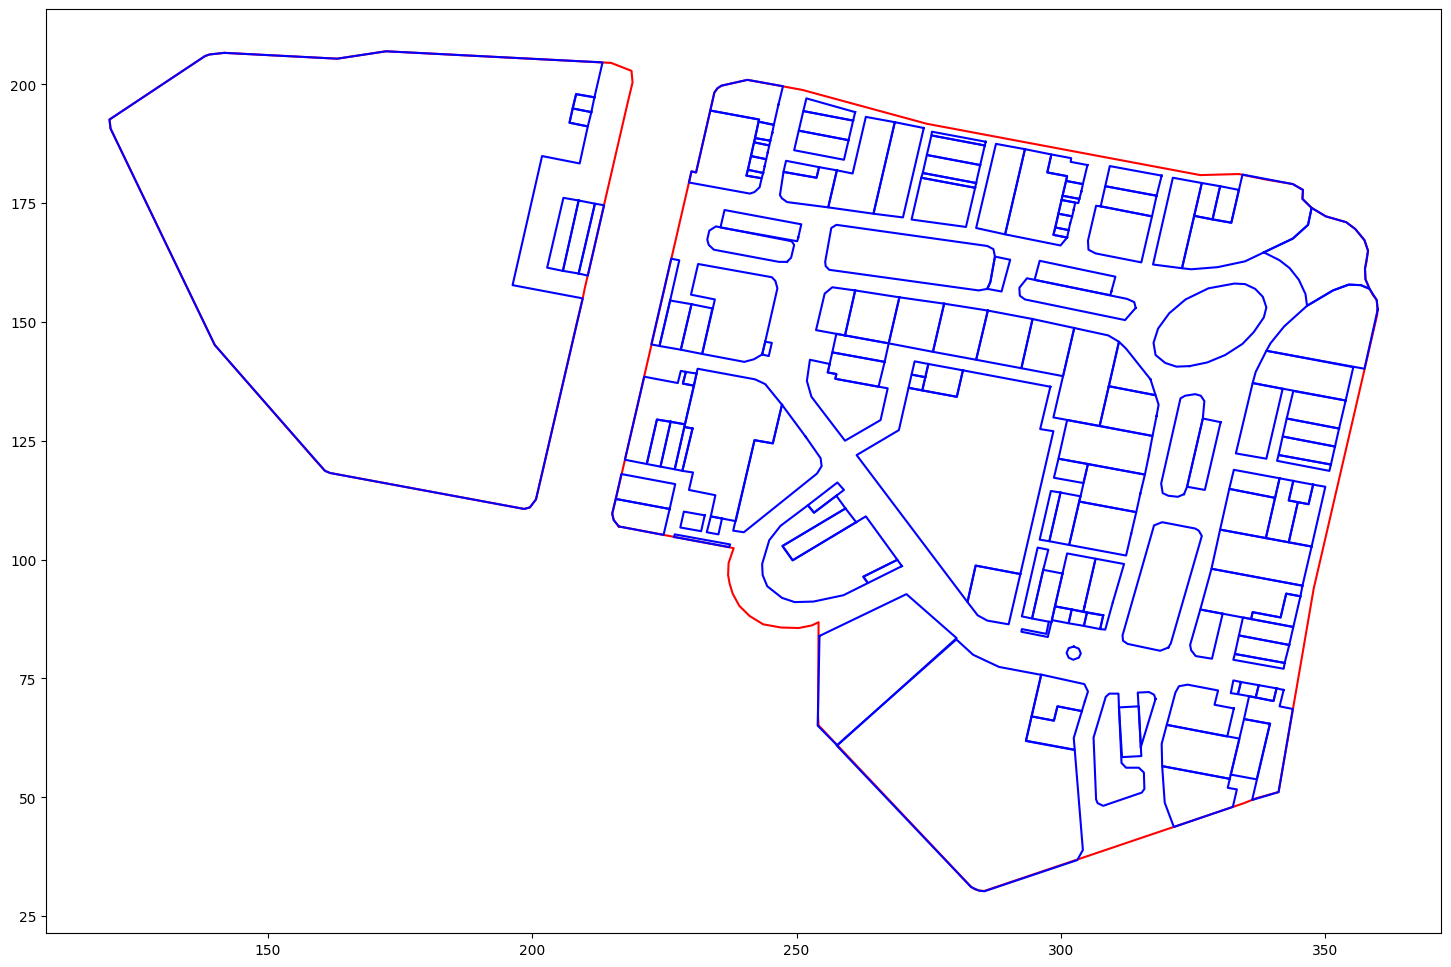

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_multipolygon.geoms:
  x, y = floor_polygon.exterior.xy
  x, y = np.array(x), np.array(y)
  x = x_min + (x - x_min) / (x_max - x_min) * width_meter
  y = y_min + (y - y_min) / (y_max - y_min) * height_meter
  ax.plot(x, y, color="red", label="floor")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  x, y = np.array(x), np.array(y)
  x = x_min + (x - x_min) / (x_max - x_min) * width_meter
  y = y_min + (y - y_min) / (y_max - y_min) * height_meter
  ax.plot(x, y, color="blue", label="store")

plt.ticklabel_format(useOffset=False)
plt.show()

In [109]:
floor_store_polygons = shapely_ops.unary_union(
  [p for p in store_polygons if floor_polygon.contains(p) or floor_polygon.intersects(p)]
)

In [110]:
floor_search_space = floor_polygon.difference(floor_store_polygons)

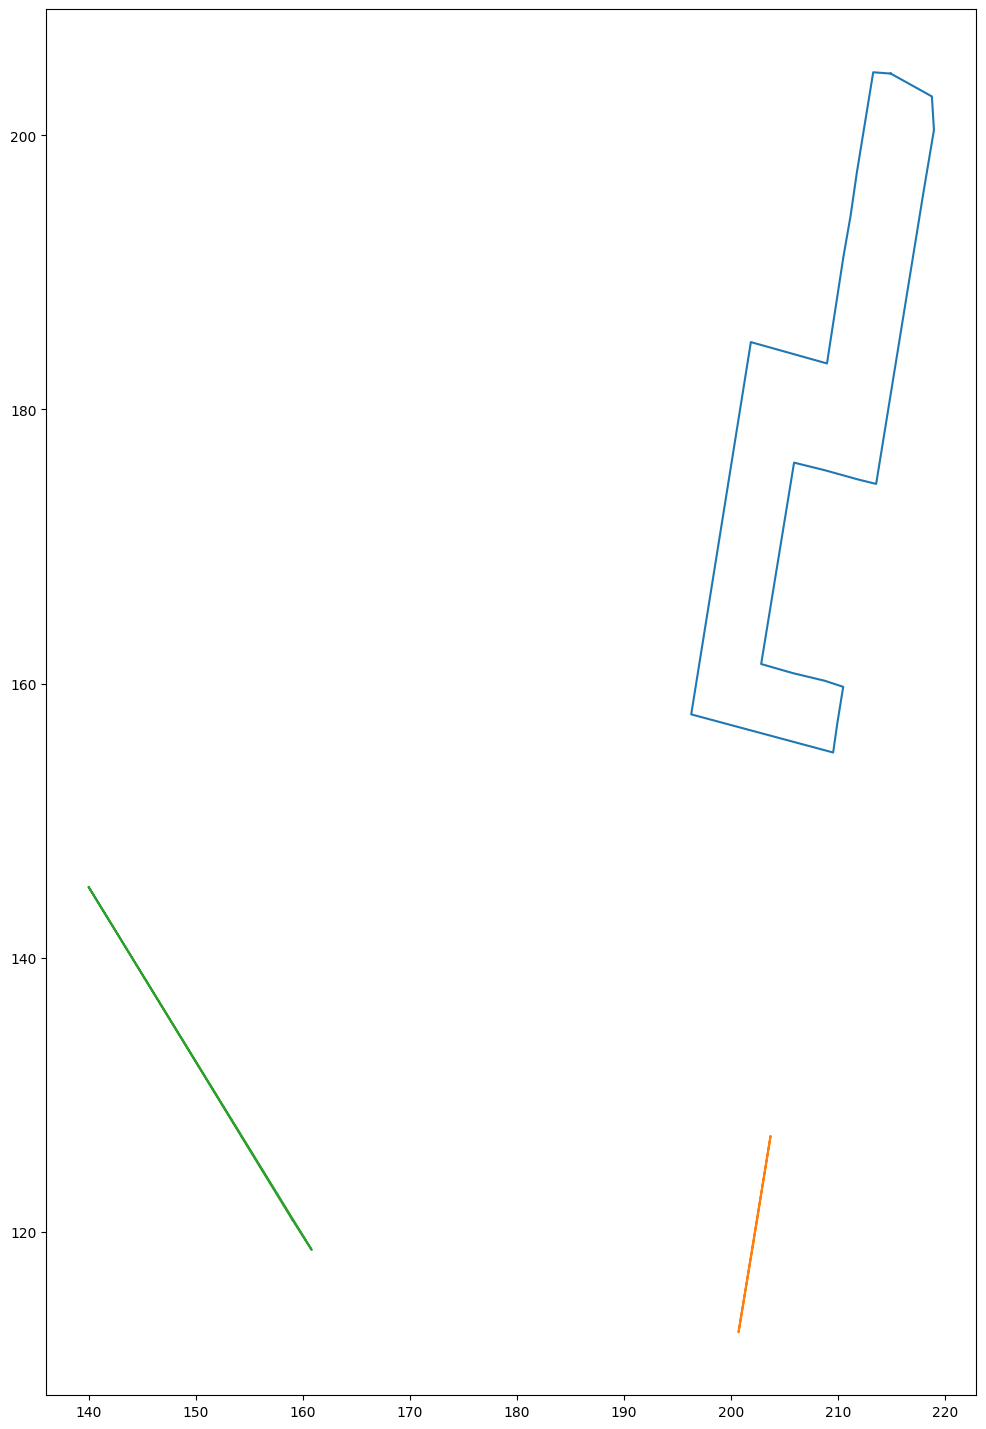

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(12, 18))

for p in floor_search_space.geoms:
  x, y = p.exterior.xy
  x, y = np.array(x), np.array(y)
  pts = np.zeros((len(x), 2), dtype=np.float32)
  pts[:, 0] = x_min + (x - x_min) / (x_max - x_min) * width_meter
  pts[:, 1] = y_min + (y - y_min) / (y_max - y_min) * height_meter
  ax.plot(pts[:, 0], pts[:, 1])

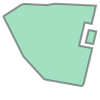

In [113]:
floor_store_polygons

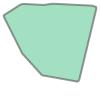

In [112]:
floor_polygon

In [ ]:
# The first multi/single polygon always describe the floor polygon

floor_feature = floor_map["features"][0]

floor_feature_type = floor_feature["geometry"]["type"]

print(f"floor_feature_type={floor_feature_type}")

if floor_feature_type == "MultiPolygon":


In [54]:
obj = shape(floor_map["features"][0]["geometry"])

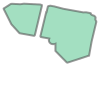

In [55]:
obj

In [ ]:
visualize_trajectory(gt_location, 
                     floor_plan_filename, 
                     floor_info["map_info"]["width"], 
                     floor_info["map_info"]["height"], 
                     title='Ground Truth', show=False)